In [13]:
# Some python notebook magic to automatically reload src files
%load_ext autoreload
%autoreload 2

# import the modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from python_fdfd.fdfd import assign_val, driven
import progressbar

In [15]:
%matplotlib inline

In [16]:
# number of x,y grid points in domain
N = (100, 100)

# spatial ranges for the domain (m)
xrange = (-2e-6, 2e-6)
yrange = (-2e-6, 2e-6)

# angular frequency of source (rad/s)
omega = 2*np.pi*200e12

# define the relative permittivity of the region (adding rectangle)
eps_r = np.ones(N, dtype=complex)
rel_permittivity = 3
within_rect1 = lambda x, y: np.logical_and.reduce((-0.5e-6<x,x<0.5e-6,-0.75e-6<y,y<0.75e-6))
eps_r = assign_val(eps_r, within_rect1, rel_permittivity, xrange, yrange)

# define the point source
Jz = np.zeros(N, dtype=complex)
Jz[N[0]//4,N[1]//2] = 1

# define number of PMLs (should have about as many PMLs points as grids in a wavelength, 10 is usually ok)
Npml = (10, 10)

In [17]:
# solve for the fields in our domain with FDFD
(Ez,Hx,Hy) = driven.solve_TM(omega, xrange, yrange, eps_r, Jz, Npml)

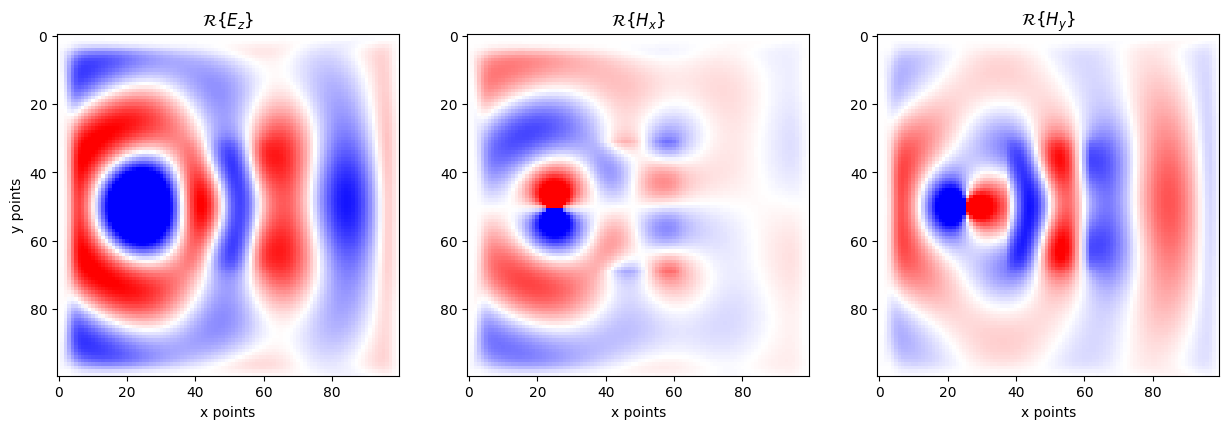

In [18]:
# plot the field components
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
Ezplt = ax1.imshow(np.real(Ez[0]).T, cmap = "bwr", vmin = -3e-7, vmax = 3e-7)
Hxplt = ax2.imshow(np.real(Hx[0]).T, cmap = "bwr", vmin = -1e-9, vmax = 1e-9)
Hyplt = ax3.imshow(np.real(Hy[0]).T, cmap = "bwr", vmin = -1e-9, vmax = 1e-9)
ax1.set_title('$\mathcal{R}\{ E_z \}$')
ax2.set_title('$\mathcal{R}\{ H_x \}$')
ax3.set_title('$\mathcal{R}\{ H_y \}$')
ax1.set_xlabel('x points')
ax2.set_xlabel('x points')
ax3.set_xlabel('x points')
ax1.set_ylabel('y points')
plt.show()

In [19]:
eta = np.zeros(N)
eta[3*N[0]//4,N[1]//2] = 1
Jz_aj = -2*np.conj(Ez*eta)*eta/1j/omega

(Ez_aj,Hx_aj,Hy_aj) = driven.solve_TM(omega, xrange, yrange, eps_r, Jz_aj, Npml)

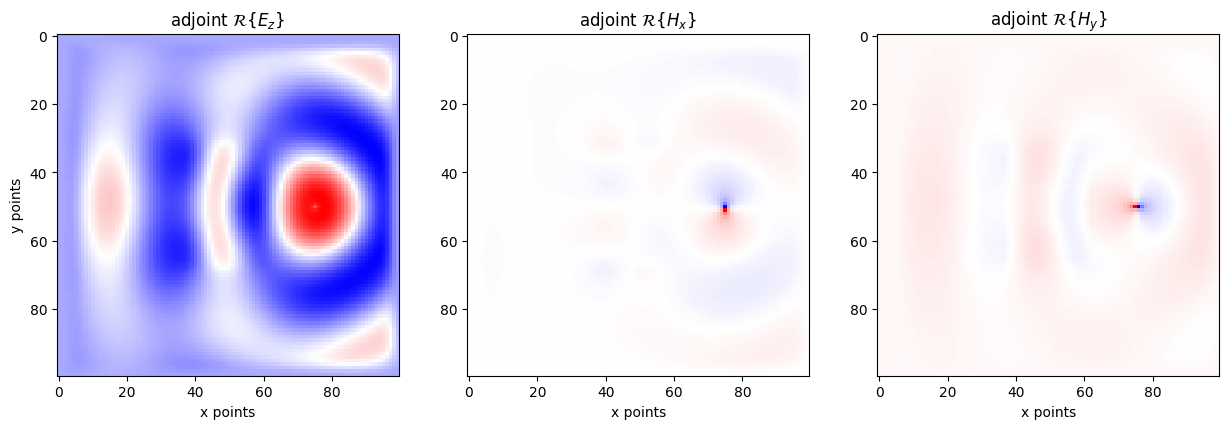

In [20]:
f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
Ezplt = ax1.imshow(np.real(Ez_aj[0]).T, cmap = "bwr")#, vmin = -2e-11, vmax = 2e-11)
Hxplt = ax2.imshow(np.real(Hx_aj[0]).T, cmap = "bwr")#, vmin = -5e-14, vmax = 5e-14)
Hyplt = ax3.imshow(np.real(Hy_aj[0]).T, cmap = "bwr")#, vmin = -5e-14, vmax = 5e-14)
ax1.set_title('adjoint $\mathcal{R}\{ E_z \}$')
ax2.set_title('adjoint $\mathcal{R}\{ H_x \}$')
ax3.set_title('adjoint $\mathcal{R}\{ H_y \}$')
ax1.set_xlabel('x points')
ax2.set_xlabel('x points')
ax3.set_xlabel('x points')
ax1.set_ylabel('y points')
plt.show()

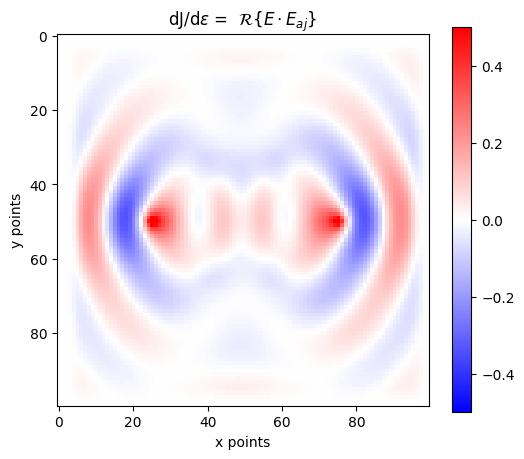

In [21]:
#plot the sensitivity map
f = plt.figure(figsize=(6,5))
max_abs = np.max(np.max(np.abs(Ez_aj[0]*Ez[0])))
Ezplt = plt.imshow(np.real(Ez_aj[0]*Ez[0]/max_abs).T, cmap = "bwr", vmin = -1/2, vmax = 1/2)
plt.title('dJ/d$\epsilon$ =  $\mathcal{R}\{ E \cdot E_{aj} \}$')
plt.xlabel('x points')
plt.ylabel('y points')
plt.colorbar()
plt.show()

In [23]:
# frequency scan
Nf = 2 # number of frequencies to scan over
freqs = np.linspace(2*np.pi*150e12, 2*np.pi*250e12, Nf)
dJde_numerical = []
dJde_AVM = []
deps = 1e-6 # size of numerical permittivity update
er = 3 # relative permittivity
e0 = 8.854e-12
# loop through freqencies (use progress bar to track progress)
pgb = progressbar.ProgressBar(max_value=Nf)
for index, w in enumerate(freqs):
    pgb.update(index+1)
    # make source
    Jz = np.zeros(N, dtype=complex)
    Jz[N[0]//4,N[1]//2] = 1
    # numerical derivative
    eps_up = np.ones(N, dtype=complex)
    eps_up = assign_val(eps_up, within_rect1, er+deps/2, xrange, yrange)
    # compute fields and objective function when permittivity increased
    (Ez_up,Hx,Hy) = driven.solve_TM(w, xrange, yrange, eps_up, Jz, Npml)
    J_up = np.abs(np.sum(np.sum(eta*Ez_up[0])))**2
    eps_down = np.ones(N, dtype=complex)
    eps_down = assign_val(eps_down, within_rect1, er-deps/2, xrange, yrange)
    # compute fields and objective function when permittivity decreased
    (Ez_down,Hx,Hy) = driven.solve_TM(w, xrange, yrange, eps_down, Jz, Npml)
    J_down = np.abs(np.sum(np.sum(eta*Ez_down[0])))**2
    # compute numerical derivative
    dJde_numerical.append((J_up - J_down)/deps)
    # adjoint derivative
    # compute original fields
    eps_r = np.ones(N, dtype=complex)
    eps_r = assign_val(eps_r, within_rect1, er, xrange, yrange)
    (Ez,Hx,Hy) = driven.solve_TM(w, xrange, yrange, eps_r, Jz, Npml)
    # construct adjoint soure (note the omega dependence..)
    Jz_aj = -2*np.conj(Ez[0]*eta)*eta/1j/w
    # solve adoint fields
    (Ez_aj,Hx_aj,Hy_aj) = driven.solve_TM(w, xrange, yrange, eps_r, Jz_aj, Npml)
    # compute adjoint derivative (summing field overlap over box region)
    dJde_AVM.append(w**2*e0*np.real(np.sum(np.sum((Ez[0]*Ez_aj[0]*(eps_r>1))))))

100% (2 of 2) |##########################| Elapsed Time: 0:00:01 ETA:  00:00:00

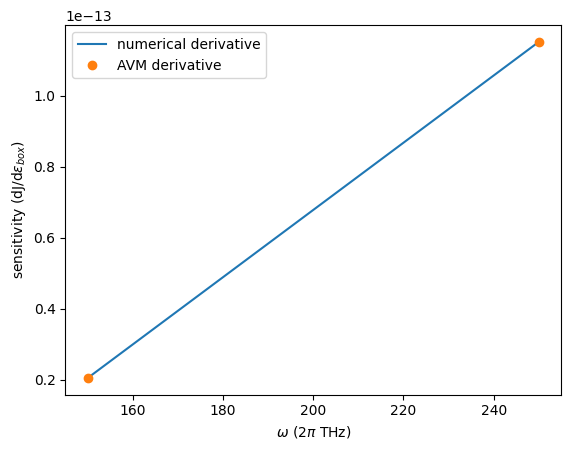

In [24]:
# Plot the results (should be perfect agreement)
num = plt.plot([f/1e12/2/np.pi for f in freqs],dJde_numerical)
avm = plt.plot([f/1e12/2/np.pi for f in freqs],dJde_AVM,'o')
plt.xlabel('$\omega$ (2$\pi$ THz)')
plt.ylabel('sensitivity (dJ/d$\epsilon_{box}$)')
plt.legend(['numerical derivative', 'AVM derivative'])
plt.show()